# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11 если с утреца не добью

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [21]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [22]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Это оценка, с помощью порогового значения надо преобразовать в предикт.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [23]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


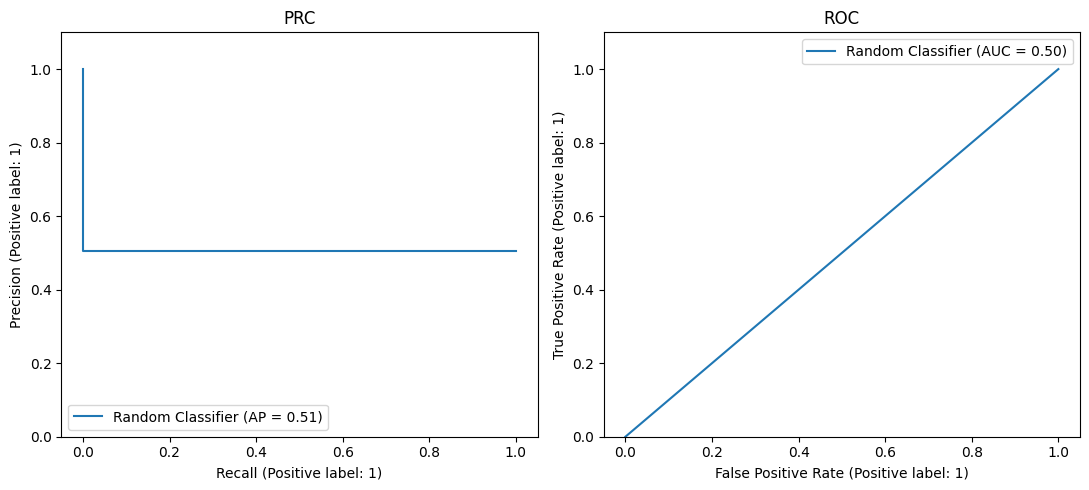

In [24]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [25]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [26]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2)

In [31]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import LinearSVC

max = -1
result = None
for C in np.logspace(-3, 3, 50):
    model = LinearSVC(C=C).fit(X_train, y_train)
    y_pred = model.predict(X_validate)
    precision, recall, _ = precision_recall_curve(y_validate, y_pred)
    now = auc(recall, precision)
    if max == -1 or now > max:
        max = now
        result = C
print(max, result)

0.8357281267955816 8.286427728546842


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

LinearSVC metrics
AUC-PR: 0.82843
AUC-ROC: 0.76786


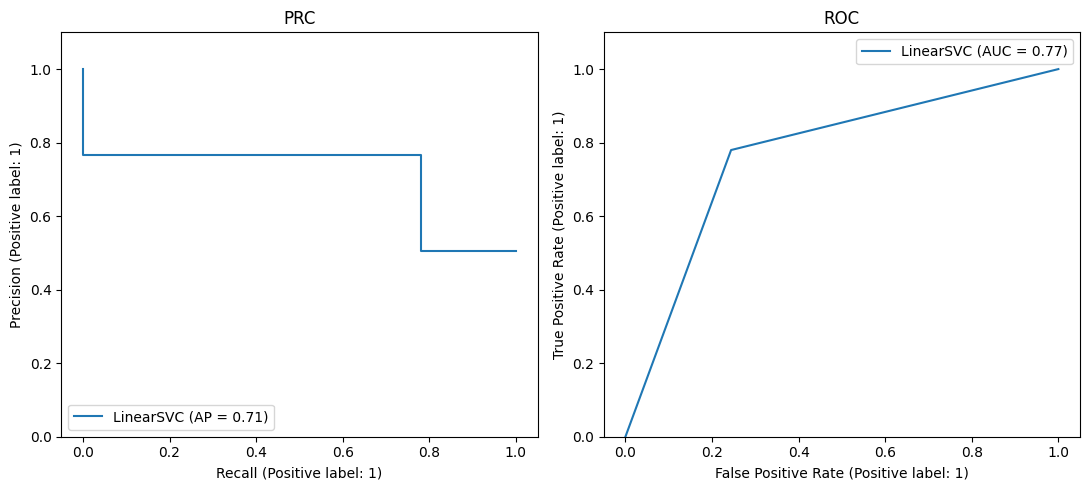

In [32]:
model = LinearSVC(C=result).fit(X_train, y_train)
y_pred = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'LinearSVC')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [33]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['LinearSVC'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred),
      result
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
LinearSVC,0.828429,0.767864,8.286428


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [36]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression

max = -1
result = None
for C in np.logspace(-3, 3, 50):
    model = LogisticRegression(penalty='l2', C=C).fit(X_train, y_train)
    y_pred = model.predict(X_validate)
    precision, recall, _ = precision_recall_curve(y_validate, y_pred)
    now = auc(recall, precision)
    if max == -1 or now > max:
        max = now
        result = C
print(max, result)

0.8327699828276197 0.002329951810515372


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier
AUC-PR: 0.75283
LinearSVC
AUC-PR: 0.83105
LogisticRegression
AUC-PR: 0.83028
Random Classifier
AUC-ROC: 0.50000
LinearSVC
AUC-ROC: 0.77130
LogisticRegression
AUC-ROC: 0.77028


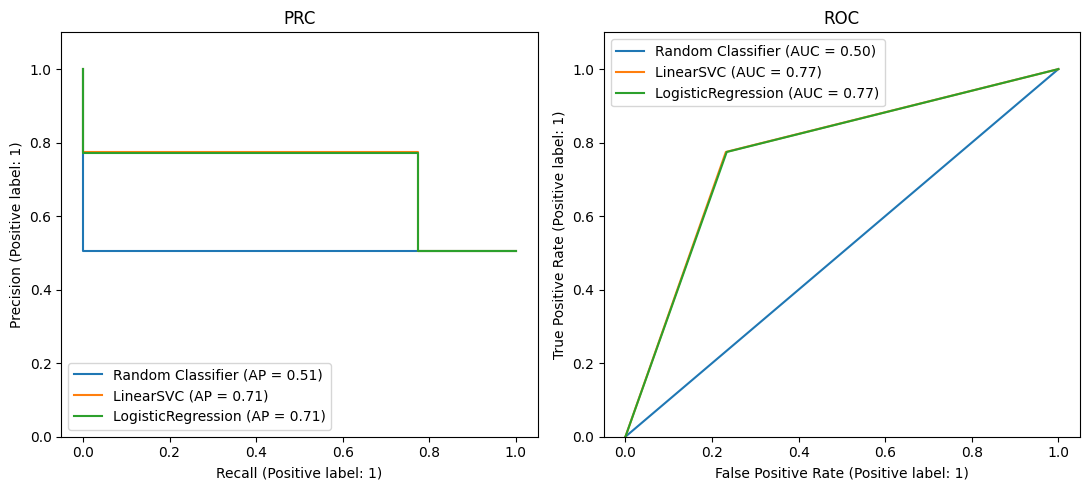

In [41]:
def depict_pr_roc_mult(y_trues, y_preds, classifier_names=['Some Classifier'], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    for i in range(len(classifier_names)):
        print(classifier_names[i])
        PrecisionRecallDisplay.from_predictions(y_trues[i], y_preds[i], ax=ax[0], name=classifier_names[i])
        precision, recall, _ = precision_recall_curve(y_trues[i], y_preds[i])
        print('AUC-PR: %.5f' % auc(recall, precision))
        ax[0].set_title("PRC")
        ax[0].set_ylim(0, 1.1)
    
    for i in range(len(classifier_names)):
        print(classifier_names[i])
        RocCurveDisplay.from_predictions(y_trues[i], y_preds[i], ax=ax[1], name=classifier_names[i])
        print('AUC-ROC: %.5f' % roc_auc_score(y_trues[i], y_preds[i]))
        ax[1].set_title("ROC")
        ax[1].set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.legend()


model = LogisticRegression(penalty='l2', C=result).fit(X_train, y_train)
y_pred_LogisticRegression = model.predict(X_test)
model = LinearSVC(C=result).fit(X_train, y_train)
y_pred_LinearSVC = model.predict(X_test)
y_random
depict_pr_roc_mult([y_test, y_test, y_test], [y_random, y_pred_LinearSVC, y_pred_LogisticRegression], ['Random Classifier',
                                                                                                  'LinearSVC',
                                                                                                  'LogisticRegression'])

In [44]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_LogisticRegression)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['LogisticRegression'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_LogisticRegression),
      result
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
LinearSVC,0.828429,0.767864,8.286428
LogisticRegression,0.830283,0.770285,0.002330


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Результаты хорошие, различий между LR и SVM почти нет, наверное потому что выборка синтетическая и не обладает свойствами для лучшей работы того или иного метода.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [76]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

from sklearn.svm import SVC

model = SVC(kernel="linear").fit(X, y)

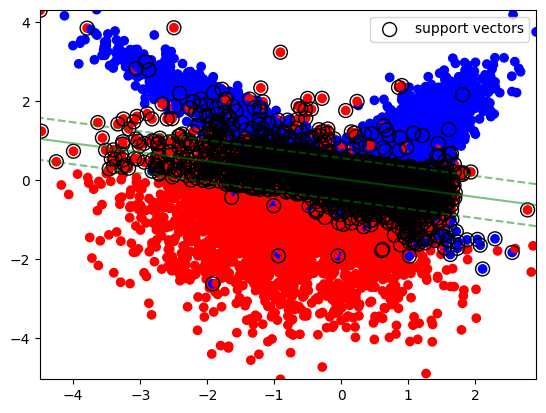

In [92]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()]) # https://gist.github.com/WittmannF/60680723ed8dd0cb993051a7448f7805
    Z = Z.reshape(XX.shape)
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    plt.contour(XX, YY, Z, colors='g', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="black",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model, True)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Минимальный набор объектов, которые лежат строго по одну сторону от разделяющей гиперплоскости и помогают в ее построении.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

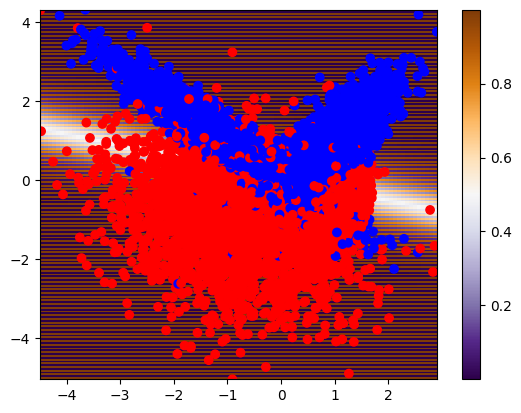

In [103]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:,1], c = y,
                cmap=cm_bright)

    plt.colorbar(image)

model = LogisticRegression(penalty='l2').fit(X, y)
plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Белым нарисована.. А теоритически почему белым? Наверное как в дурке стены не знаю.. 

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [113]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)]))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, color='green')
    plt.ylim([-0.05, 1.05])
    plt.grid()

def get_points(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)]))
    return [bin_middle_points, bin_real_ratios]

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

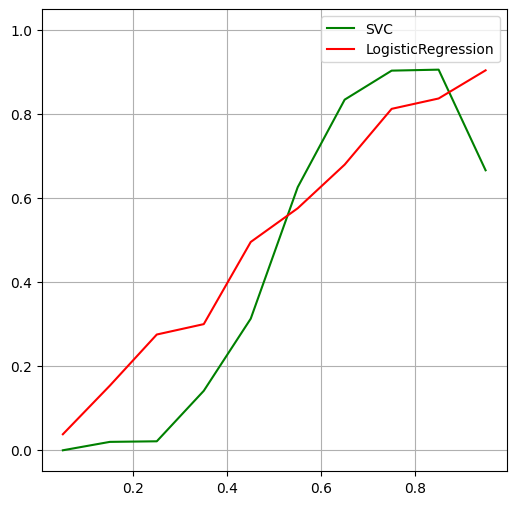

In [118]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_SVC = LinearSVC().fit(X_train, y_train)
model_LogisticRegression = LogisticRegression(penalty='l2').fit(X_train, y_train)
pred_SVC = model_SVC.decision_function(X_test)
pred_LogisticRegression = model_LogisticRegression.predict_proba(X_test)[:, 1] # seminars
pred_SVC = (pred_SVC - pred_SVC.min()) / (pred_SVC.max() - pred_SVC.min())
points_SVC = get_points(y_test, pred_SVC)
points_LogisticRegression = get_points(y_test, pred_LogisticRegression)
plt.figure(figsize=(6,6))
plt.plot(points_SVC[0], points_SVC[1], color='green', label='SVC')
plt.plot(points_LogisticRegression[0], points_LogisticRegression[1], color='red', label='LogisticRegression')
plt.ylim([-0.05, 1.05])
plt.legend()
plt.grid()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** на диагональ не очень то и похоже => нет

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

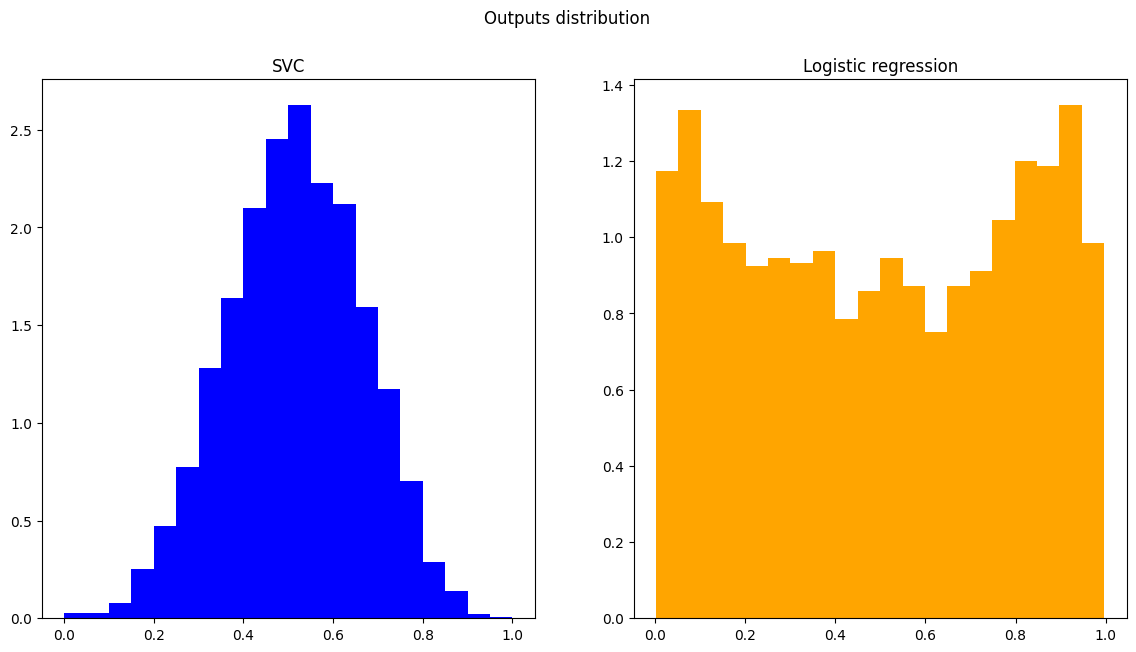

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7)) # copied from seminar

axs[0].hist(pred_SVC, bins=20, color='blue', density='True')
axs[1].hist(pred_LogisticRegression, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Как я это понимаю -- в случае SVC есть разделяющая прямая и большинство объектов кластеризуются так, что они находятся на примерно схожем расстоянии от прямой, поэтому их значения сконцентрированы на относительно небольшом отрезке
В случае с Logistic regression такой цели нет, так что значения распределены относительно равномерно с гладкой границей между классами.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

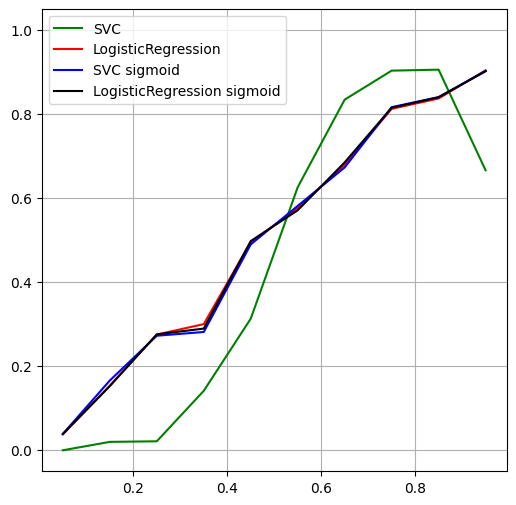

In [129]:
from sklearn.calibration import CalibratedClassifierCV
sigmoid_SVC = CalibratedClassifierCV(model_SVC, cv=3, method='sigmoid').fit(X_train, y_train) # copied from seminar
sigmoid_SVC_pred = sigmoid_SVC.predict_proba(X_test)[:, 1]
sigmoid_LogisticRegression = CalibratedClassifierCV(model_LogisticRegression, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_LogisticRegression_pred = sigmoid_LogisticRegression.predict_proba(X_test)[:, 1]
points_SVC_sigmoid = get_points(y_test, sigmoid_SVC_pred)
points_LogisticRegression_sigmoid = get_points(y_test, sigmoid_LogisticRegression_pred)
plt.figure(figsize=(6,6))
plt.plot(points_SVC[0], points_SVC[1], color='green', label='SVC')
plt.plot(points_LogisticRegression[0], points_LogisticRegression[1], color='red', label='LogisticRegression')
plt.plot(points_SVC_sigmoid[0], points_SVC_sigmoid[1], color='blue', label='SVC sigmoid')
plt.plot(points_LogisticRegression_sigmoid[0], points_LogisticRegression_sigmoid[1], color='black', label='LogisticRegression sigmoid')
plt.ylim([-0.05, 1.05])
plt.legend()
plt.grid()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Для SVC ощутимо да, для LogisticRegression не особо.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Рассмотрим изотоническую регрессию. Она представляет собой изотоническую функцию — кусочно-линейную возрастающую функцию. Этот метод склонен к переобучению, поэтому не факт, что на нашей маленькой выборке он даст хороший результат.

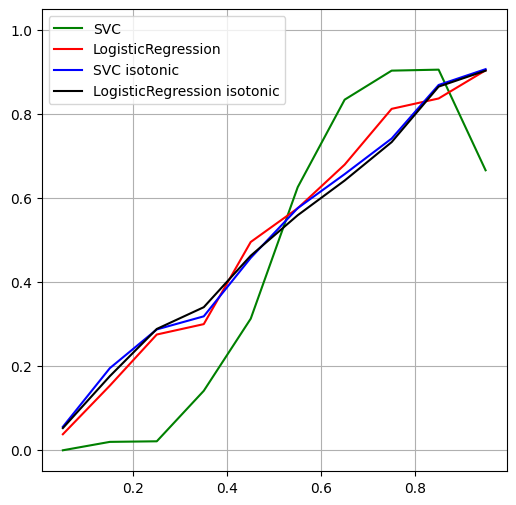

In [132]:
from sklearn.calibration import CalibratedClassifierCV

isotonic_SVC = CalibratedClassifierCV(model_SVC, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_SVC_pred = isotonic_SVC.predict_proba(X_test)[:, 1]

isotonic_LogisticRegression = CalibratedClassifierCV(model_LogisticRegression, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_LogisticRegression_pred = isotonic_LogisticRegression.predict_proba(X_test)[:, 1]

points_SVC_isotonic = get_points(y_test, isotonic_SVC_pred)
points_LogisticRegression_isotonic = get_points(y_test, isotonic_LogisticRegression_pred)

plt.figure(figsize=(6,6))
plt.plot(points_SVC[0], points_SVC[1], color='green', label='SVC')
plt.plot(points_LogisticRegression[0], points_LogisticRegression[1], color='red', label='LogisticRegression')
plt.plot(points_SVC_isotonic[0], points_SVC_isotonic[1], color='blue', label='SVC isotonic')
plt.plot(points_LogisticRegression_isotonic[0], points_LogisticRegression_isotonic[1], color='black', label='LogisticRegression isotonic')
plt.ylim([-0.05, 1.05])
plt.legend()
plt.grid()

Вопреки моим ожиданиям этот метод наоборот помог улучшить результат и теперь кривые явно ближе к диагонали.

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [152]:
df = pd.read_csv('bike_buyers.csv')
# Заменим пропуски категориальных переменных
df[['Marital Status', 'Gender', 'Home Owner']] = df[['Marital Status', 'Gender', 'Home Owner']].fillna(value='undefined')
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

# Разделим на категориальные признаки и числовые
df.info()
X_numerical = X[['Income', 'Children', 'Cars', 'Age']]
X_categorical = X[['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    1000 non-null   object 
 2   Gender            1000 non-null   object 
 3   Income            994 non-null    float64
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        1000 non-null   object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB


В начале поработаем только с категориальными признаками

In [183]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [184]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ("ore", OrdinalEncoder(), ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region'])
])

pipeline = Pipeline([
    ("ore", column_transformer),
    ("LogisticRegression", LogisticRegression(penalty='l2'))
])

import time
start = time.time()
pipline = pipeline.fit(X_train, y_train)
prediction = pipline.predict(X_test)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}")

Качество: 0.6261569579288027, время: 0.019103050231933594


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [393]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region'])
])

pipeline = Pipeline([
    ("ohe", column_transformer),
    ("LogisticRegression", LogisticRegression(penalty='l2'))
])

import time
start = time.time()
pipline = pipeline.fit(X_train, y_train)
prediction = pipline.predict(X_test)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}")

Качество: 0.7048893557422969, время: 0.019145727157592773


Если честно не понимаю что значит посмотреть как изменилось качество модели в сравнении с тем что было до кодирования, как мы без него модель научим, когда у нас там строки какие-то.. Туплю наверное. Не знаю....

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [187]:
cats = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

X_train['Purchased Bike'] = y_train
X_test['Purchased Bike'] = y_test

for cat in cats:
    tmp = X_train[['Purchased Bike', cat]].groupby(by=[cat], as_index=False).mean()
    values = dict(zip(tmp[cat], tmp['Purchased Bike']))
    X_train[f'{cat}_avg'] = X_train[cat].map(values)
    X_test[f'{cat}_avg'] = X_test[cat].map(values)
X_train = X_train.drop(columns=['Purchased Bike'])
X_test = X_test.drop(columns=['Purchased Bike'])

mt_encoded = ['Marital Status_avg', 'Gender_avg', 'Education_avg', 'Occupation_avg', 'Home Owner_avg', 'Commute Distance_avg', 'Region_avg']

column_transformer = ColumnTransformer([
    ("donttouch", 'passthrough', mt_encoded)
])

pipeline = Pipeline([
    ("nothing", column_transformer),
    ("LogisticRegression", LogisticRegression(penalty='l2'))
])

import time
start = time.time()
pipline = pipeline.fit(X_train, y_train)
prediction = pipline.predict(X_test)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}")


Качество: 0.6782549019607844, время: 0.004680633544921875


По времени получилось быстрее других трансформеров, но это глупости потому что я заранее поменял значения и трансформера тут нет


Можно было бы перенести часть с созданием колонок в отрезок измерения времени, но лучше я напишу в следующем задании нормальный трансформер и сравню там

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [210]:
from sklearn.base import BaseEstimator, TransformerMixin

class MTEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.features = []
        self.values = {}

    def fit(self, X, y):
        cop = X.copy()
        self.features = list(cop.columns)
        cop['target'] = y
        for feature in self.features:
            tmp = cop[['target', feature]].groupby(by=[feature], as_index=False).mean()
            self.values[feature] = dict(zip(tmp[feature], tmp['target']))
        cop = cop.drop(columns=['target'])

        return self
    
    def transform(self, X):
        for feature in self.features:
            X[feature] = X[feature].map(self.values[feature])
        return X

column_transformer = ColumnTransformer([
    ("mte", MTEncoder(), ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region'])
])

pipeline = Pipeline([
    ("ColumnTransformer", column_transformer),
    ("LogisticRegression", LogisticRegression(penalty='l2'))
])

import time
start = time.time()
pipline = pipeline.fit(X_train, y_train)
prediction = pipline.predict(X_test)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}")

Качество: 0.6782549019607844, время: 0.020557403564453125


По времени совсем немного дольше других трансформеров работает, но в пределах погрешности как мне кажется

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [325]:
from sklearn.base import BaseEstimator, TransformerMixin

class MTEncoderWithNoise(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.features = []
        self.values = {}
        self.noise_constant = 0.06

    def fit(self, X, y):
        cop = X.copy()
        self.features = list(cop.columns)
        cop['target'] = y
        for feature in self.features:
            tmp = cop[['target', feature]].groupby(by=[feature], as_index=False).mean()
            self.values[feature] = dict(zip(tmp[feature], tmp['target']))
        cop = cop.drop(columns=['target'])

        return self
    
    def transform(self, X):
        for feature in self.features:
            noise = np.random.uniform(low=-self.noise_constant, high=self.noise_constant, size=(X[feature].shape[0],))
            X[feature] = X[feature].map(self.values[feature]) + noise
        return X

column_transformer = ColumnTransformer([
    ("mtenoise", MTEncoderWithNoise(), ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region'])
])

pipeline = Pipeline([
    ("ColumnTransformer", column_transformer),
    ("LogisticRegression", LogisticRegression(penalty='l2'))
])

import time
start = time.time()
pipline = pipeline.fit(X_train, y_train)
prediction = pipline.predict(X_test)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}")

Качество: 0.7157407407407408, время: 0.024790048599243164


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Качество заметно выросло. Произошло это очевидно потому что модель меньше переобучилась на целевой переменной и лучше себя показала на тестовой выборке.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [365]:
from sklearn.base import BaseEstimator, TransformerMixin

class MTEncoderWithNoiseAndFolds(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.features = []
        self.noise_constant = 0.06
        self.folds_number = 4
        self.values = [{}] * self.folds_number

    def fit(self, X, y):
        cop = X.copy()
        self.features = list(cop.columns)
        cop['target'] = y
        for feature in self.features:
            all = cop[['target', feature]].groupby(by=[feature], as_index=False).sum()
            for fold in range(self.folds_number):
                fold_df = cop[cop.index % self.folds_number == fold]
                in_fold = fold_df[['target', feature]].groupby(by=[feature], as_index=False).sum()
                out_fold = all.copy()
                out_fold['target'] = (all['target'] - in_fold['target']) / (cop.shape[0] - fold_df.shape[0])
                fold_values = dict(zip(out_fold[feature], out_fold['target']))
                self.values[fold][feature] = fold_values
        cop = cop.drop(columns=['target'])

        return self
    
    def transform(self, X):
        for feature in self.features:
            noise = np.random.uniform(low=-self.noise_constant, high=self.noise_constant, size=(X[feature].shape[0],))
            for fold in range(self.folds_number):
                X[feature][X.index % self.folds_number == fold] = X[X.index % self.folds_number == fold][feature].map(
                                                                                                self.values[fold][feature])
            X[feature] += noise

        return X

column_transformer = ColumnTransformer([
    ("mtenoisefolds", MTEncoderWithNoiseAndFolds(), ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region'])
])

pipeline = Pipeline([
    ("ColumnTransformer", column_transformer),
    ("LogisticRegression", LogisticRegression(penalty='l2'))
])

import time
start = time.time()
pipline = pipeline.fit(X_train, y_train)
prediction = pipline.predict(X_test)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}")

Качество: 0.7178470319634703, время: 0.11970043182373047


Качество немного выросло, однако время работы увеличилось в разы.

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding




In [577]:
from sklearn.base import BaseEstimator, TransformerMixin

class MTEncoderC(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.features = []
        self.values = {}
        self.C = 2
        self.noise_constant = 0.06

    def fit(self, X, y):
        cop = X.copy()
        self.features = list(cop.columns)
        cop['target'] = y
        mn = y.mean()
        for feature in self.features:
            tmp = cop[['target', feature]].groupby(by=[feature], as_index=False).sum()
            tmp['target'] = (tmp['target'] + self.C * mn) / (cop.shape[0] + self.C)
            self.values[feature] = dict(zip(tmp[feature], tmp['target']))
        cop = cop.drop(columns=['target'])

        return self
    
    def transform(self, X):
        for feature in self.features:
            noise = np.random.uniform(low=-self.noise_constant, high=self.noise_constant, size=(X[feature].shape[0],))
            X[feature] = X[feature].map(self.values[feature]) + noise
        return X

column_transformer = ColumnTransformer([
    ("MTEncoderC", MTEncoderC(), ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region'])
])

pipeline = Pipeline([
    ("ColumnTransformer", column_transformer),
    ("LogisticRegression", LogisticRegression(penalty='l2'))
])

import time
start = time.time()
pipline = pipeline.fit(X_train, y_train)
prediction = pipline.predict(X_test)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}")

Качество: 0.7173787878787878, время: 0.02149677276611328


Получилось кажется..

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [585]:
df['Income'].fillna((df['Income'].mean()), inplace=True)
df['Children'].fillna((df['Children'].mean()), inplace=True)
df['Cars'].fillna((df['Cars'].mean()), inplace=True)
df['Age'].fillna((df['Age'].mean()), inplace=True)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [587]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

# Разделим на категориальные признаки и числовые
df.info()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    1000 non-null   object 
 2   Gender            1000 non-null   object 
 3   Income            1000 non-null   float64
 4   Children          1000 non-null   float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        1000 non-null   object 
 8   Cars              1000 non-null   float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               1000 non-null   float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB


In [594]:
from sklearn.base import BaseEstimator, TransformerMixin

class MTEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.features = []
        self.values = {}

    def fit(self, X, y):
        cop = X.copy()
        self.features = list(cop.columns)
        cop['target'] = y
        for feature in self.features:
            tmp = cop[['target', feature]].groupby(by=[feature], as_index=False).mean()
            self.values[feature] = dict(zip(tmp[feature], tmp['target']))
        cop = cop.drop(columns=['target'])

        return self
    
    def transform(self, X):
        for feature in self.features:
            X[feature] = X[feature].map(self.values[feature])
        return X

features = list(X.columns)
if 'ID' in features:
    features.remove('ID')
column_transformer = ColumnTransformer([
    ("mte", MTEncoder(), features)
])

pipeline = Pipeline([
    ("ColumnTransformer", column_transformer),
    ("LogisticRegression", LogisticRegression(penalty='l2'))
])

import time
start = time.time()
pipline = pipeline.fit(X_train, y_train)
prediction = pipline.predict(X_test)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}")

Качество: 0.6804367816091954, время: 0.03227829933166504


Не понимаю что значит вместе, у нас 4 числовых признака, мне все попарно пытаться сделать или все комбинации?.. Реально дурка короче

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Из плюсов счетчиков -- меньшее количество признаков, с таким и мне приятнее работать и модели думаю тоже, а из минусов может сильно переобучаться, особенно на категориях с большим количеством возможных значений

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [595]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-22 03:08:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: ‘adult.data’

adult.data              [       <=>          ]   3,79M  2,21MB/s    за 1,7s    

2023-11-22 03:08:19 (2,21 MB/s) - ‘adult.data’ сохранён [3974305]



In [612]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
12413,27,Private,298871,Bachelors,13,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,40,Philippines,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [610]:
X = df.drop(columns=['income'])
y = (df['income']).astype('int64')

# Разделим на категориальные признаки и числовые
df.info()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 3.6+ MB


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [617]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
print(sum(list(map(len, OneHotEncoder().fit(X_train[categorical]).categories_))), 'категории')

102 категории


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [621]:
from sklearn.preprocessing import StandardScaler
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline([
    ("ColumnTransformer", column_transformer),
    ("LogisticRegression", LogisticRegression(penalty='l2'))
])

import time
start = time.time()
pipline = pipeline.fit(X_train, y_train)
prediction = pipline.predict(X_test)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}")

Качество: 0.7194042858848961, время: 0.139434814453125


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [660]:
from sklearn.preprocessing import StandardScaler
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

transformed = column_transformer.fit_transform(X_train, y_train)
model = LogisticRegression(penalty='l2').fit(transformed, y_train)
ids = np.argpartition(model.coef_[0], -40)[-40:] # какой-то мусор с https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array ниче не понял
transformed = transformed[:, ids]
model = LogisticRegression(penalty='l2').fit(transformed, y_train)
print(ids)

import time
start = time.time()
test_transformed = column_transformer.transform(X_test)[:, ids]
prediction = model.predict(test_transformed)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}") 

[103   4  54  99  23  48  74  69  45 107   1  19  98  81  42 101  84 102
  65  33  13  12  90  35  43   5  44 106  96  82  52  71  70  26  27  62
 104 105  61  36]
Качество: 0.7193739023310457, время: 0.009846925735473633


Качество немного ухудшилось

Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [661]:
from sklearn.preprocessing import StandardScaler
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ('scaling', "passthrough", numeric)
])

transformed = column_transformer.fit_transform(X_train, y_train)
model = LogisticRegression(penalty='l2').fit(transformed, y_train)
ids = np.argpartition(model.coef_[0], -40)[-40:] # какой-то мусор с https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array ниче не понял
transformed = transformed[:, ids]
model = LogisticRegression(penalty='l2').fit(transformed, y_train)

import time
start = time.time()
test_transformed = column_transformer.transform(X_test)[:, ids]
prediction = model.predict(test_transformed)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}") 

Качество: 0.6957202004881358, время: 0.009190797805786133


Без масштабирования ожидаемо ухудшилось

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [669]:
from sklearn.preprocessing import StandardScaler
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

transformed = column_transformer.fit_transform(X_train, y_train)
ss = StandardScaler(with_mean=False).fit(transformed, y_train)
transformed = ss.transform(transformed)
model = LogisticRegression(penalty='l2').fit(transformed, y_train)
ids = np.argpartition(model.coef_[0], -40)[-40:] # какой-то мусор с https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array ниче не понял
transformed = transformed[:, ids]
model = LogisticRegression(penalty='l2').fit(transformed, y_train)
print(ids)

import time
start = time.time()
test_transformed = ss.transform(column_transformer.transform(X_test))[:, ids]
prediction = model.predict(test_transformed)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}") 

[ 69  65  97  34  71  98  74  62  44  90  96  61 101  81  82  17  84  51
   5  70   1  26  45  59  43 103  52  18  48  19  42  21  23  36 102 106
 107 105 104  27]
Качество: 0.7166398872214087, время: 0.010039567947387695


Качество еще немного упало..

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [726]:
from sklearn.preprocessing import StandardScaler
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

transformed = column_transformer.fit_transform(X_train, y_train)
first = transformed[y_train == 0]
second = transformed[y_train == 1]
mu_1, mu_2 = np.mean(first, axis = 0), np.mean(second, axis = 0)
sig_1, sig_2 = np.std(first.toarray(), axis = 0), np.std(second.toarray(), axis = 0)
n_1, n_2 = transformed.shape[0] - transformed.sum(axis=0), transformed.sum(axis=0)
cnt_plus = transformed.sum(axis=0)
t = np.abs(mu_1 - mu_2) / (np.sqrt((n_1 * (sig_1**2)[:, None] + n_2 * (sig_2**2)[:, None]) / (transformed.shape[0])))
ids = np.argpartition(np.asarray(t)[0], -40)[-40:]
transformed = transformed[:, ids]
model = LogisticRegression(penalty='l2').fit(transformed, y_train)

test_transformed = column_transformer.transform(X_test)[:, ids]
prediction = model.predict(test_transformed)
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}") 

Качество: 0.7085761747724686


Столько потел чтобы это заработало, а качество не выросло

Как будто изначально у меня оно почему-то дофига высокое не знаю

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [727]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

In [731]:
from sklearn.preprocessing import StandardScaler
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ('scaling', "passthrough", numeric)
])
import time
start = time.time()
transformed = column_transformer.fit_transform(X_train, y_train)
model = LogisticRegression(penalty='l2').fit(transformed, y_train)
ids = list(range(len(model.coef_[0])))
for _ in range(len(ids) - 40):
    mn, to_remove = 100, -1
    for id in ids:
        nw_ids = ids.copy()
        nw_ids.remove(id)
        nw_transformed = transformed[:, nw_ids] # на этом моменте задумался что айдис очень похоже на адис. сосмыслом...
        model = LogisticRegression(penalty='l2').fit(nw_transformed, y_train)

        validate_transformed = column_transformer.transform(X_validate)[:, nw_ids]
        prediction = model.predict(validate_transformed)
        precision, recall, _ = precision_recall_curve(y_validate, prediction)
        res = auc(recall, precision)
        if res < mn:
            mn = res
            to_remove = id
    ids.remove(to_remove)
    print(f"Текущее количество признаков: {len(ids)}")

test_transformed = column_transformer.transform(X_test)[:, ids]
prediction = model.predict(test_transformed)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}") 

Текущее количество признаков: 107
Текущее количество признаков: 106
Текущее количество признаков: 105
Текущее количество признаков: 104
Текущее количество признаков: 103
Текущее количество признаков: 102
Текущее количество признаков: 101
Текущее количество признаков: 100
Текущее количество признаков: 99
Текущее количество признаков: 98
Текущее количество признаков: 97
Текущее количество признаков: 96
Текущее количество признаков: 95
Текущее количество признаков: 94
Текущее количество признаков: 93
Текущее количество признаков: 92
Текущее количество признаков: 91
Текущее количество признаков: 90
Текущее количество признаков: 89
Текущее количество признаков: 88
Текущее количество признаков: 87
Текущее количество признаков: 86
Текущее количество признаков: 85
Текущее количество признаков: 84
Текущее количество признаков: 83
Текущее количество признаков: 82
Текущее количество признаков: 81
Текущее количество признаков: 80
Текущее количество признаков: 79
Текущее количество признаков: 78
Те

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [732]:
from sklearn.preprocessing import StandardScaler
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ('scaling', "passthrough", numeric)
])
import time
start = time.time()
transformed = column_transformer.fit_transform(X_train, y_train)
model = LogisticRegression(penalty='l2').fit(transformed, y_train)
ids = list(range(len(model.coef_[0])))
now = []
for _ in range(40):
    mx, to_add = -1, -1
    for id in ids:
        if id in now:
            continue
        nw_ids = now.copy()
        nw_ids.append(id)
        nw_transformed = transformed[:, nw_ids] # на этом моменте задумался что айдис очень похоже на адис. сосмыслом...
        model = LogisticRegression(penalty='l2').fit(nw_transformed, y_train)

        validate_transformed = column_transformer.transform(X_validate)[:, nw_ids]
        prediction = model.predict(validate_transformed)
        precision, recall, _ = precision_recall_curve(y_validate, prediction)
        res = auc(recall, precision)
        if res > mx:
            mx = res
            to_add = id
    now.append(to_add)
    print(f"Текущее количество признаков: {len(now)}, качество: {res}")

test_transformed = column_transformer.transform(X_test)[:, now]
prediction = model.predict(test_transformed)
duration = time.time() - start
precision, recall, _ = precision_recall_curve(y_test, prediction)
print(f"Качество: {auc(recall, precision)}, время: {duration}") 

Текущее количество признаков: 1, качество: 0.27512911798626083
Текущее количество признаков: 2, качество: 0.2746126460412175
Текущее количество признаков: 3, качество: 0.29956021720727605
Текущее количество признаков: 4, качество: 0.29956021720727605
Текущее количество признаков: 5, качество: 0.30397545796216896
Текущее количество признаков: 6, качество: 0.29859702491281437
Текущее количество признаков: 7, качество: 0.2998524552199201
Текущее количество признаков: 8, качество: 0.2998524552199201
Текущее количество признаков: 9, качество: 0.2998524552199201
Текущее количество признаков: 10, качество: 0.2998524552199201
Текущее количество признаков: 11, качество: 0.30696843993547285
Текущее количество признаков: 12, качество: 0.30577125346158707
Текущее количество признаков: 13, качество: 0.34542445971017405
Текущее количество признаков: 14, качество: 0.34322761045450123
Текущее количество признаков: 15, качество: 0.34545697465756686
Текущее количество признаков: 16, качество: 0.35090014

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** К лучшему качеству привел встроенный метод
Про методы: 

Встроенный быстрый и удобный. Из минусов так же как и фильтрация не учитывает связь признаков относительно друг друга.

Фильтрация тоже быстрая, показала хороший результат, я думаю она более масштабируемая. Из ее минусов она не учитывает связь признаков относительно друг друга, как будто не подходит для нелинейных моделей и зависит от распределения в данных.

Последний метод как я увидел довольно медленный и у меня он показал плохие результаты вопреки ожиданиям. Думаю он крут тем, что рассматривает признаки относительно друг друга (точнее признак относительно набора признаков), а не какого-то скора на всей выборке. Возможно из-за маленькой выборки или маленького количества признаков он не раскрыл свой потенциал, но там и помереть можно пока досчитается.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [733]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-22 05:38:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: ‘bank-additional.zip’

bank-additional.zip     [    <=>             ] 434,15K   559KB/s    за 0,8s    

2023-11-22 05:38:13 (559 KB/s) - ‘bank-additional.zip’ сохранён [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional 

In [734]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [735]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [739]:
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
splitter = KFold(n_splits=5, shuffle=True,
                                  random_state=500)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [758]:
categorial = ['job', 'marital', 'education', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
from sklearn.preprocessing import StandardScaler
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorial),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline([
    ("ColumnTransformer", column_transformer),
    ("LogisticRegression", LogisticRegression(penalty='l2'))
])
for i, (train_index, test_index) in enumerate(splitter.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipline = pipeline.fit(X_train, y_train)
    prediction = pipline.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, prediction)
    print(f"Fold number: {i + 1}, Качество: {auc(recall, precision)}, время: {duration}")

Fold number: 1, Качество: 0.5253553896156369, время: 162.47356009483337
Fold number: 2, Качество: 0.4793975762461117, время: 162.47356009483337
Fold number: 3, Качество: 0.47334080852294125, время: 162.47356009483337
Fold number: 4, Качество: 0.5083411359621491, время: 162.47356009483337
Fold number: 5, Качество: 0.45326665629733864, время: 162.47356009483337


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [768]:
calls_number = []
earn = []
for i, (train_index, test_index) in enumerate(splitter.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipline = pipeline.fit(X_train, y_train)
    prediction = pipline.predict(X_test)
    calls_number.append(np.sum(prediction))
    true = y_test&prediction
    earn.append(np.sum(true) * 10)
print('Выручка', sum(earn) / len(earn), 'рублей')
print('Отдадим операторам', sum(calls_number) / len(calls_number), 'рублей')
print('Заработали', sum(earn) / len(earn) - sum(calls_number) / len(calls_number), 'рублей')
print('Стандартное отклонение', np.std(earn), 'рублей')

Выручка 2128.0 рублей
Отдадим операторам 323.0 рублей
Заработали 1805.0 рублей
Стандартное отклонение 110.34491379306978 рублей


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [772]:
calls_number = []
earn = []
for i, (train_index, test_index) in enumerate(splitter.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipline = pipeline.fit(X_train, y_train)
    prediction = pipline.predict(X_test)
    calls_number.append(np.sum(prediction))
    true = y_test&prediction
    earn.append(np.sum(true * np.random.uniform(0,20, len(true))))
print('Выручка', sum(earn) / len(earn), 'рублей')
print('Отдадим операторам', sum(calls_number) / len(calls_number), 'рублей')
print('Заработали', sum(earn) / len(earn) - sum(calls_number) / len(calls_number), 'рублей')
print('Стандартное отклонение', np.std(earn), 'рублей')

Выручка 2094.9593137400616 рублей
Отдадим операторам 323.0 рублей
Заработали 1771.9593137400616 рублей
Стандартное отклонение 146.90244385488762 рублей


Стандартное отклонение выросло, большой разброс, большая неопределенность, большие риски....

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [781]:
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorial),
    ('scaling', StandardScaler(), numeric)
])

max = -np.inf
result = None
space = np.logspace(-2, 2, 25)
earns = []
st = []
for C in space:
    calls_number = []
    earn = []
    for i, (train_index, test_index) in enumerate(splitter.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        pipeline = Pipeline([
            ("ColumnTransformer", column_transformer),
            ("LogisticRegression", LogisticRegression(penalty='l2', C=C))
        ])
        pipline = pipeline.fit(X_train, y_train)
        prediction = pipline.predict(X_test)
        calls_number.append(np.sum(prediction))
        true = y_test&prediction
        earn.append(np.sum(true * np.random.uniform(0,20, len(true))))
    if sum(earn) / len(earn) - sum(calls_number) / len(calls_number) > max:
        max = sum(earn) / len(earn) - sum(calls_number) / len(calls_number)
        result = C
    earns.append(sum(earn) / len(earn))
    st.append(np.std(earn))
calls_number = []
earn = []
for i, (train_index, test_index) in enumerate(splitter.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline = Pipeline([
        ("ColumnTransformer", column_transformer),
        ("LogisticRegression", LogisticRegression(penalty='l2', C=result))
    ])
    pipline = pipeline.fit(X_train, y_train)
    prediction = pipline.predict(X_test)
    calls_number.append(np.sum(prediction))
    true = y_test&prediction
    earn.append(np.sum(true * np.random.uniform(0,20, len(true))))
print('Лучший C: ', result)
print('Выручка', sum(earn) / len(earn), 'рублей')
print('Отдадим операторам', sum(calls_number) / len(calls_number), 'рублей')
print('Заработали', sum(earn) / len(earn) - sum(calls_number) / len(calls_number), 'рублей')
print('Стандартное отклонение', np.std(earn), 'рублей')


Лучший C:  14.67799267622069
Выручка 2147.251362130227 рублей
Отдадим операторам 325.0 рублей
Заработали 1822.2513621302269 рублей
Стандартное отклонение 90.80302771708817 рублей


Ну небольшой выиграш есть да

Text(0.5, 1.0, 'Зависимость заработка от коэффициента C')

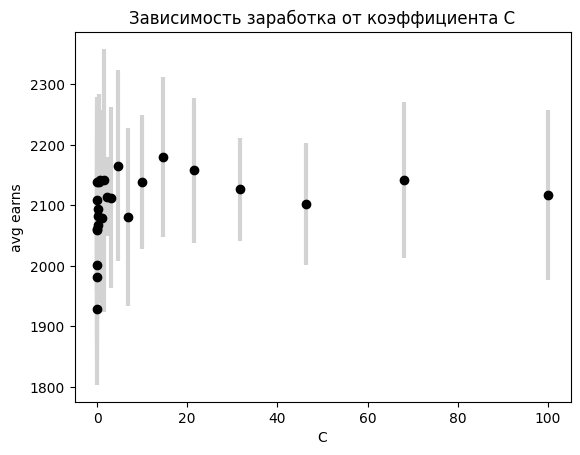

In [783]:
plt.errorbar(space, earns, yerr=st, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
plt.xlabel('C')
plt.ylabel('avg earns')
plt.title('Зависимость заработка от коэффициента C')

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [784]:
for _ in range(5):
    max = -np.inf
    result = None
    earns = []
    st = []
    for C in space:
        calls_number = []
        earn = []
        for i, (train_index, test_index) in enumerate(splitter.split(X)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipeline = Pipeline([
                ("ColumnTransformer", column_transformer),
                ("LogisticRegression", LogisticRegression(penalty='l2', C=C))
            ])
            pipline = pipeline.fit(X_train, y_train)
            prediction = pipline.predict(X_test)
            calls_number.append(np.sum(prediction))
            true = y_test&prediction
            earn.append(np.sum(true * np.random.uniform(0,20, len(true))))
        if sum(earn) / len(earn) - sum(calls_number) / len(calls_number) > max:
            max = sum(earn) / len(earn) - sum(calls_number) / len(calls_number)
            result = C
        earns.append(sum(earn) / len(earn))
        st.append(np.std(earn))
    calls_number = []
    earn = []
    for i, (train_index, test_index) in enumerate(splitter.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        pipeline = Pipeline([
            ("ColumnTransformer", column_transformer),
            ("LogisticRegression", LogisticRegression(penalty='l2', C=result))
        ])
        pipline = pipeline.fit(X_train, y_train)
        prediction = pipline.predict(X_test)
        calls_number.append(np.sum(prediction))
        true = y_test&prediction
        earn.append(np.sum(true * np.random.uniform(0,20, len(true))))
    print('Лучший C: ', result)

Лучший C:  14.67799267622069
Лучший C:  2.154434690031882
Лучший C:  31.622776601683793
Лучший C:  0.06812920690579612
Лучший C:  1.467799267622069


В первый раз результат повторился, далее нет, ну рандом, что сказатб..

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [ ]:
#your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ я не завтракал :c